a-Si 512 atom, getting eigenvector and frequency based on phonopy, then evaluate dynamic structure factor

In [1]:
import numpy as np
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from ase.io import read

atoms=read('optimized.vasp',format='vasp')



In [2]:
unitcell = PhonopyAtoms(symbols=atoms.symbols,
                    cell=atoms.cell,
                    positions=atoms.positions)
phonon = Phonopy(unitcell,
                [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                primitive_matrix=[[1,0,0],[0,1,0],[0,0,1]],log_level=1)

In [3]:
import pyAF.data_parse
FC_file='FORCE_CONSTANTS_2ND'
natom=len(atoms.positions)
#read as ndarray, no mass scaling here
fc_phonopy=pyAF.data_parse.read_fc_phonopy_noscale(FC_file,natom)

In [4]:
fc_phonopy.shape

(512, 512, 3, 3)

In [5]:
phonon.set_force_constants(fc_phonopy)
phonon.symmetrize_force_constants(show_drift=True)
symetrized_fc=phonon.force_constants

Max drift of force constants: -0.000000 (zx) -0.000000 (xz)
Max drift after symmetrization by translation: 0.000000 (xx) 0.000000 (xx)


In [6]:
#getting eigenvector and freq at k=0

mesh = [1, 1, 1]
phonon.run_mesh(mesh,with_eigenvectors=True)
mesh_dict = phonon.get_mesh_dict()
frequencies = mesh_dict['frequencies']
eigenvectors =mesh_dict['eigenvectors']

In [7]:
frequencies.shape, eigenvectors.shape

((1, 1536), (1, 1536, 1536))

phonopy yaml format: Eigenvector at each phonon mode. Each eigenvector e of dynamical matrix is shown as sets of three complex values of each atom along the Cartesian axes in the primitive cell. The real and imaginary values correspond to the left and right, respectively. A set of eigenvectors comprising all bands at a q-point forms a unitary matrix obtained as the result of numpy.linalg.eigh, i.e., LAPACK of routine _heevd. Therefore eigenvectors correspond to the column vectors of the unitary matrix.

Eigenvectors corresponding to phonopy yaml output are obtained as follows.
```
if eigvecs is not None:
    for eigvecs_at_q in eigvecs:
        for vec in eigvecs_at_q.T:
            print vec
```

In [8]:
k=np.array([0.1,0.0,0.0])
dsf=np.zeros(natom*3)
for i,vec in enumerate(eigenvectors.T):
    for j in range(natom):
        nstart=3*j
        nend=3*(j+1)
        disp=np.squeeze(vec)[nstart:nend]
        pos=atoms.positions[j]
        phase=np.exp(1.0j*np.dot(k,pos))
        polarlization=np.dot(k,disp)
        factor=phase*polarlization
        dsf[i]=dsf[i]+factor*np.conjugate(factor)



<ipython-input-8-7660fe097abb>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  dsf[i]=dsf[i]+factor*np.conjugate(factor)


In [9]:
dsf[0:30]

array([1.80478386e-24, 2.84734311e-30, 1.00000000e-02, 3.47394078e-03,
       3.26998206e-03, 5.84186915e-03, 1.53990280e-03, 6.22601996e-03,
       2.34939415e-03, 2.60274483e-03, 1.37851467e-03, 4.36070854e-03,
       2.68405406e-03, 2.32810244e-03, 2.77843584e-03, 4.31123613e-03,
       2.85543310e-03, 3.83809146e-03, 2.02255061e-03, 3.87110603e-03,
       3.47189923e-03, 2.93441563e-03, 3.57414943e-03, 3.86468384e-03,
       2.95888517e-03, 4.28003031e-03, 3.36845102e-03, 2.35711666e-03,
       3.62223981e-03, 3.69396667e-03])

In [10]:
nmodes=natom*3
dyn_file='Dyn.form'
lammps_dyn=np.loadtxt(dyn_file).reshape((nmodes,nmodes))

In [11]:
eigenvalue, eigenvector=np.linalg.eigh(lammps_dyn)

In [12]:
k=np.array([0.01,0.0,0.0])
dsf=np.zeros(natom*3)
for i,vec in enumerate(eigenvector.T):
    for j in range(natom):
        nstart=3*j
        nend=3*(j+1)
        disp=np.squeeze(vec)[nstart:nend]
        pos=atoms.positions[j]
        phase=np.exp(1.0j*np.dot(k,pos))
        polarlization=np.dot(k,disp)
        factor=phase*polarlization
        dsf[i]=dsf[i]+factor*np.conjugate(factor)

<ipython-input-12-3733f0f60bea>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  dsf[i]=dsf[i]+factor*np.conjugate(factor)


In [13]:
dsf[0:100]

array([5.47917592e-05, 2.09537892e-06, 4.31128619e-05, 3.47332668e-05,
       3.27136927e-05, 5.84105338e-05, 1.54418080e-05, 6.22135303e-05,
       2.35026953e-05, 2.60211436e-05, 1.37610222e-05, 4.36377952e-05,
       2.68369284e-05, 2.32805524e-05, 2.77832001e-05, 4.31102466e-05,
       2.85478879e-05, 3.83887324e-05, 2.02173348e-05, 3.87175418e-05,
       3.47258418e-05, 2.93430128e-05, 3.57397482e-05, 3.86455407e-05,
       2.95916570e-05, 4.28073799e-05, 3.36856283e-05, 2.35971219e-05,
       3.62078082e-05, 3.69316192e-05, 3.34308866e-05, 3.03006522e-05,
       2.66185552e-05, 3.96187297e-05, 4.13842029e-05, 1.76977247e-05,
       5.70231943e-05, 1.60904491e-05, 3.58883909e-05, 2.52340261e-05,
       3.64872609e-05, 3.88881909e-05, 3.70644337e-05, 2.34456954e-05,
       2.62033699e-05, 3.30908097e-05, 3.18161822e-05, 3.29223579e-05,
       4.22909689e-05, 3.65207126e-05, 3.01920323e-05, 3.48216315e-05,
       3.03212661e-05, 3.79511286e-05, 3.95705943e-05, 4.55761576e-05,
      

In [14]:
import pyAF.constants
pc=pyAF.constants.physical_constants()
omega=[]
#extract minimum index of negative frequency
mode_negative=0
for i in range(nmodes):
    if eigenvalue[i] <0.0:
        val=-np.sqrt(-eigenvalue[i])*pc.scale_cm
        omega.append(val)
        mode_negative=i
    else:
        val=np.sqrt(eigenvalue[i])*pc.scale_cm
        omega.append(val)

In [15]:
omega

[-0.01390557323519556,
 -0.01116633417385397,
 0.020597837743009103,
 38.05866640151176,
 52.17024513465031,
 52.35643321861239,
 53.822171078339295,
 53.97376808218776,
 54.72079800775221,
 56.04444762458789,
 56.82848751736935,
 57.043386999628474,
 57.593769639095306,
 58.52258603806131,
 59.78233267705958,
 60.50767674826034,
 68.18617127734647,
 68.51995666689109,
 70.13118340184553,
 70.85300705113643,
 72.80554073651514,
 73.69949795796316,
 74.06177897561483,
 74.41944214985693,
 75.2058133485031,
 76.32427770519398,
 76.96115098632384,
 77.7802297771545,
 77.93689506222402,
 78.54509728225001,
 79.29233713916581,
 79.66348838974088,
 80.23386974474191,
 80.66702880207217,
 81.2391238316149,
 81.81624995982753,
 82.00265019662173,
 83.03052697331724,
 84.00459215673445,
 84.42897259279364,
 85.24515447967522,
 85.65789564844586,
 86.22922101755904,
 87.71297485613391,
 89.02148430081505,
 90.05138848990559,
 90.6060075268961,
 91.57125844972023,
 92.35318312011849,
 93.07088248

In [16]:
bins=np.linspace(0,100,101)

In [17]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [18]:
def broadening(omega1, omega2, sigma):
    delta=1.0/np.pi*sigma/((omega1-omega2)**2+sigma*sigma)
    return delta

In [19]:
sigma=1.0
smearing=np.zeros(len(bins))
for i,e in enumerate(bins):
    val=0.0
    for j,w in enumerate(omega):
        val=val+broadening(w,e,sigma)*dsf[j]
    smearing[i]=val

In [20]:
smearing

array([3.21997226e-05, 1.63189202e-05, 6.76400652e-06, 3.58432747e-06,
       2.27998156e-06, 1.63922363e-06, 1.28321641e-06, 1.06795746e-06,
       9.29887965e-07, 8.37636515e-07, 7.74337984e-07, 7.30299917e-07,
       6.99648764e-07, 6.78671213e-07, 6.64939770e-07, 6.56826868e-07,
       6.53222932e-07, 6.53367033e-07, 6.56742600e-07, 6.63012508e-07,
       6.71979253e-07, 6.83562315e-07, 6.97788621e-07, 7.14794699e-07,
       7.34841437e-07, 7.58345189e-07, 7.85933202e-07, 8.18538916e-07,
       8.57567523e-07, 9.05193254e-07, 9.64919752e-07, 1.04270438e-06,
       1.14939635e-06, 1.30656291e-06, 1.56223370e-06, 2.04069440e-06,
       3.13307805e-06, 6.29191096e-06, 1.21616891e-05, 7.08105251e-06,
       3.62687707e-06, 2.56081730e-06, 2.21422579e-06, 2.14285839e-06,
       2.22017001e-06, 2.41512966e-06, 2.74186902e-06, 3.25814139e-06,
       4.09960137e-06, 5.59536966e-06, 8.68061799e-06, 1.65937901e-05,
       3.58805337e-05, 3.85353806e-05, 4.32316055e-05, 3.36884866e-05,
      

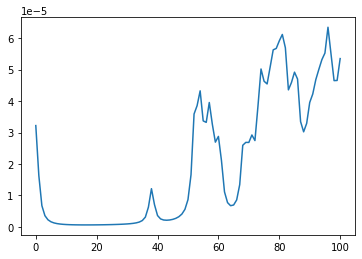

In [21]:
import matplotlib.pyplot as plt 
plt.plot(bins,smearing)

志賀さんのコードをそのまま移植してみる

In [22]:
a=atoms.cell[0,0]
np.pi*2/a

0.28704346084346016

In [41]:
nom=100
nwn=10

ommin=np.min(omega)
ommax=np.max(omega)
om=np.linspace(ommin,ommax,nom)
Gmin=0.02
Gmax=10*Gmin
wn=np.linspace(Gmin,Gmax,nwn)

dsf_L=np.zeros([nwn,nom])
dsf_T=np.zeros([nwn,nom])

EL=np.zeros([nwn,nmodes])

ei=eigenvector.reshape([3,natom,nmodes])

q=np.array([np.ones(natom),np.zeros(natom),np.zeros(natom)])


In [42]:
q.shape

(3, 512)

In [43]:
for ind, w in enumerate(omega):
    for ik in range(nwn):
        k=wn[ik]*q
        phase=np.exp(1.0j*np.dot(k,atoms.positions))
        EL[ik,ind]=EL[ik,ind]+np.linalg.norm(np.dot(np.dot(k,ei[:,:,ind].T),phase))**2/3


In [44]:
sigma=1.0
for iw in range(nom):
    for ik in range(nwn):
        for ind in range(nmodes):
            dsf_L[ik,iw]=dsf_L[ik,iw]+EL[ik,ind]*broadening(om[iw],omega[ind],sigma)

In [45]:
dsf_L[0,:]

array([8.90757108e-02, 1.89897311e-03, 4.84856944e-04, 2.18855618e-04,
       1.26540606e-04, 8.90859207e-05, 7.51798687e-05, 6.24889928e-05,
       3.65045446e-04, 1.21065741e-04, 3.28872431e-04, 7.35775748e-04,
       9.69260248e-04, 3.71592851e-04, 3.88303968e-04, 4.32554826e-04,
       2.21225350e-04, 6.99752095e-04, 6.97111183e-04, 4.05802091e-04,
       6.90136129e-04, 6.62401494e-04, 6.59894806e-04, 8.70465183e-04,
       8.76714207e-04, 1.09232738e-03, 1.07724819e-03, 1.23517971e-03,
       1.03230293e-03, 1.05013243e-03, 7.60584258e-04, 8.50010844e-04,
       6.27622760e-04, 8.63411773e-04, 7.85599889e-04, 5.36927160e-04,
       8.99081542e-05, 2.22800286e-04, 2.78400127e-04, 1.43737335e-04,
       1.45024193e-04, 4.74229785e-04, 2.04967103e-04, 1.82141924e-04,
       6.88253271e-04, 4.87407846e-04, 4.73544165e-04, 4.41134628e-04,
       6.36835193e-04, 8.14023685e-04, 2.57283364e-04, 8.45746413e-04,
       3.25733300e-04, 2.93827751e-04, 2.94819598e-04, 4.42358949e-04,
      

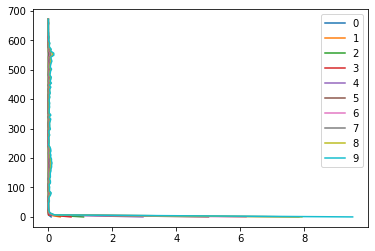

In [46]:
for ik in range(nwn):
    plt.plot(dsf_L[ik,:],om,label=str(ik))
plt.legend()